<h1> NLP Project </h1>
<h2 style ="color:blue"> Search Engine and Literature Clustering</h2>
<p>This notebook utilizes two major topics in natural language processing to tackle and answer questions related to COVID-19. The first one is: a <i>search engine</i> which allows the user to enter a query and fetches for them the most relevant papers related to that query (max 5). The other topic is <i>literature clustering</i> where PCA algorithm was used to reduce the dimension of the data, followed by K-means which was used to cluster the papers.</p>

In [1]:
import nltk
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #import the regular expression library
import string
import os
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  
import matplotlib.pyplot as plt 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# !pip install scispacy scipy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
import en_core_sci_lg  
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h4>STEP 1: DATA PREPROCESSING</h4>


<p> Before applying the NLP techniques on the data, data must be preprocessed, cleaned, structured,etc. In the following cell, the folder(s) containing the data in the json format are accessed. Each json file has, then, three majors information extracted from it:<br/>
 <ol>
     <li>The title of the paper</li>
     <li>The abstract of the paper</li>
     <li>The body/full text of the paper</li>
</ol>
These are then added to the list which will contain all the papers with those 3 features or attributes. The list is then converted to a dataframe which will be used later in this notebook.

In [2]:
FullPaper=[]#a list which will save all the papers 
directories = ["biorxiv_medrxiv"] #the folder name which contains the papers
for directory in directories: #for each of the folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb")) #load the json version of the file
        title = paper['metadata']['title'] #set the title variable to the file's title
        try:
            abstract = paper['abstract']#set the abstract variable to the file's abstract
        except:
            abstarct=""   #set the abstract variable to the an empty string if the file does not have an abstract             
        full_text="" #create an empty string which will hold the body of the paper (file)    
        
        for text in paper['body_text']: #for every word in the body of the file
            full_text += (text['text'] +'\n') #concatenate the word to the variable full_text
        FullPaper.append([title,abstract,full_text]) #since the 3 variable: title, abstract, full_text, now have a value, a paper can be created and added to the FullPaper list
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])#create a dataframe which will hold all the papers

100%|██████████| 1934/1934 [00:51<00:00, 37.63it/s]


<h5>Data Cleaning</h5>
<p>In the below cell, each body text for each paper is stripped off stop words, punctuation, and is lemmatized. The <i>en_core_sci_lg</i> model was used as it works well on biomedical and scientific papers </p>

In [3]:
full_text = FullPaperDataframe['full_text'].head(50)

clean_text = [] #a list which will hold the clean paper text (after data processing)
dirty_text = []# a list which will hold the dirty paper text (before data processing)
# Intializing parser lemmtizer
lemmatizer = WordNetLemmatizer()

# Using the scispacy library to get the biomedical terms 
parser=en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

# extending and customizing the stopwords list (Since we found these words in the text before adding the our_stopwords list)
all_stopwords = stopwords.words('english')
# 'the','we','it','they',
our_stopwords=['copyright','https','et','al','preprint',
               'this','these','also','however','although','among','in','medrxiv'
                'biorxiv','license','without','fig','figure','doi']
all_stopwords.extend(our_stopwords)

pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~"""

#  removing all stop words and extracting puctuations
for val in tqdm(full_text):
    val = val.lower()
    body_tokens = word_tokenize(val)
    paper_body_without_stopwords =  [token for token in body_tokens if not token in all_stopwords and nltk.pos_tag([token.lower()])!='PRP']#a list which will hold the tokens stripped off stop words and words that aren't pronouns
    dirty_paper_tokens = [token for token in body_tokens] #will hold the tokens as is
    clean_string = ' '.join(paper_body_without_stopwords) #convert the list into string
    clean_string = re.sub(rf"[{pattern}]", '', clean_string) #Strip punctuation from the text
    clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string) # from single letters from the text
    clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove digits that aren't associated with a word from the text
    clean_text.append(clean_string)
    dirty_string=' '.join(dirty_paper_tokens)#convert the list of the dirty tokens into a string
    dirty_text.append(dirty_string) #this list will be used later for analysis
lemmatized_text=[]    # a list which will carry the lemmatized text

# applying the parserer on the dataset
for val in tqdm(clean_text):
    lemmatized_string=[]
    words=val.split(' ')
    for word in words:
        if(len(word)>1):
            token = parser(word)
            lemm_token = lemmatizer.lemmatize(token.text)
            lemmatized_string.append(lemm_token)
    if(len(lemmatized_string)>0):
        lemmatized_text.append(lemmatized_string)
        
for i in range(len(lemmatized_text)):
    lemmatized_text[i]=" ".join(lemmatized_text[i])
    
#print(lemmatized_text)

100%|██████████| 50/50 [07:53<00:00,  9.48s/it]


<h5> Corpus Word Count Graph Before Vs. After Data Cleaning </h5>

<p>To demonstrate how effective the data cleaning is, below is a bar chart comparing the corpus word count before and after the data cleaning.</p>

1087654
721462


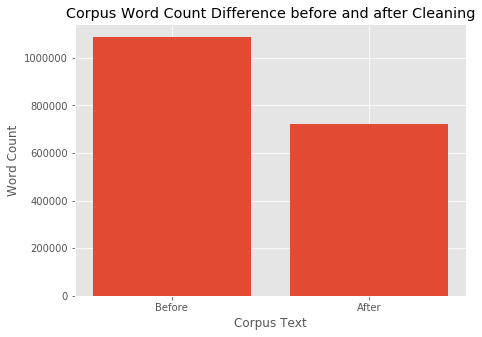

In [4]:

count1=0
count2 =0

for d in dirty_text: #get the word count in all the corpus before preprocessing
    count1 +=len(d)

for st in lemmatized_text:#get the word count in all the corpus after preprocessing
    count2+=len(st)
labels_x=["Before", "After"]
values = [count1, count2]
print(count1)
print(count2)
plt.figure(figsize=(7, 5))
plt.bar(labels_x, values)
plt.xlabel('Corpus Text')
plt.ylabel('Word Count')
plt.title('Corpus Word Count Difference before and after Cleaning')
plt.show()

<h4>STEP 2: SEARCH ENGINE IMPLEMENTATION</h4>

<h5>TF-IDF</h5>
<p> After the data has been preprocessed, a TF-IDF matrix is to be created. This is a matrix which will hold the values of each word (bag of words of all the corpus) with respect to the document (paper).</p> 

In [5]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05,max_df = 0.8)
#For the above vectorizer, the first paramater specifies that the 1+log(tf) is going to be used instead of tf.
#The second parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The third parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(lemmatized_text) #fit and transform the lemmatized texts which were previously cleaned.
print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())

[('005', 0), ('02', 1), ('03', 2), ('08', 3), ('10', 4), ('100', 5), ('11', 6), ('12', 7), ('14', 8), ('15', 9), ('16', 10), ('17', 11), ('18', 12), ('19', 13), ('1a', 14), ('1b', 15), ('1c', 16), ('1d', 17), ('1e', 18), ('1f', 19), ('1x', 20), ('20', 21), ('2019', 22), ('2020', 23), ('202002', 24), ('21', 25), ('22', 26), ('24', 27), ('25', 28), ('29', 29), ('2a', 30), ('2b', 31), ('2c', 32), ('2d', 33), ('34', 34), ('36', 35), ('37', 36), ('3a', 37), ('3b', 38), ('3c', 39), ('3d', 40), ('40', 41), ('4a', 42), ('4b', 43), ('4c', 44), ('4d', 45), ('4e', 46), ('50', 47), ('56', 48), ('5a', 49), ('5b', 50), ('60', 51), ('64', 52), ('70', 53), ('80', 54), ('abcam', 55), ('ability', 56), ('able', 57), ('absence', 58), ('absolute', 59), ('abstract', 60), ('abundance', 61), ('abundant', 62), ('academic', 63), ('accelerate', 64), ('acceptable', 65), ('access', 66), ('accessed', 67), ('accessible', 68), ('accession', 69), ('according', 70), ('account', 71), ('accounted', 72), ('accounting', 73

<h5>Cosine Similarity</h5>
<p> Cosine similarity is then utilized to get the documents which are closest to the query. The closer the cosine similairty value is to 1, the closer the document is to the query (The more likely it is going to be output). However, for this notebook, we choose to display the top 5 papers with cosine similarity greater than or equal <i>0.05</i></p>

TO BE DONE BY MARWA: ALLOW THE USER TO SPECIFIY THE NUMBER OF PAPERS THEY NEED BELOW.

In [6]:

#Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
flag = False # a flag to indicate whether or not a result is found
pd.set_option('display.max_colwidth', -1)#to avoid dataframe column's data truncation
query = input("Enter your query: ") #get the query from the user
finalQuery="" #create an empty string
words = query.split(' ') #split the query on spaces
for word in words: #for each word in the query
    word = word.lower()
    if(word!=""): #if the word is not an empty string
        if (word=="coronaviruses"):#since lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
            word ="coronavirus"
        lem_query = lemmatizer.lemmatize(word)#lemmatize the word
        finalQuery+=lem_query+" " #lemmatize the word and concat it to the string finalQuery
query = [finalQuery.strip()]# remove any trailing spaces from the query
query_tfidf = v.transform(query)
cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten() #get the cosine similarity list 
#IF NO RESULT
print(cosineSimilarities)
countzero_in2 = np.count_nonzero(cosineSimilarities) #get the number of non zero values in cosine similarity
print(countzero_in2)
if (countzero_in2==0):#if no cosine similarity which is =/= 0
    flag = True

else:
    if (countzero_in2>=5):#if there are more than 5 values greater than 5 output them
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-5:] #get the top 5 indices with the highest cosine similarity
    else:
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-countzero_in2:] #get the top countzero_in2 indices with the highest cosine 
        

Enter your query: Disease models, including animal models for infection, disease and transmission
[0.         0.03693019 0.0179142  0.03528486 0.03113854 0.02035675
 0.02866587 0.03323057 0.06159476 0.04618913 0.04417707 0.07551328
 0.07389494 0.05689733 0.01344277 0.05986187 0.03435464 0.0714156
 0.06604365 0.01861146 0.02636804 0.02523612 0.11636686 0.00739147
 0.02907127 0.05758492 0.03211481 0.07185563 0.04177113 0.03840933
 0.07099454 0.0907126  0.0604962  0.04291679 0.01485367 0.06180363
 0.05574986 0.04597954 0.08139144 0.08626283 0.07601238 0.04192381
 0.03769992 0.03570903 0.06541948 0.03990278 0.05945098 0.03098262
 0.0825372  0.04451283]
49


[0.0813914399975159, 0.0825372018004221, 0.08626282754240032, 0.09071259745287173, 0.11636685845984387]
[38, 48, 39, 31, 22]


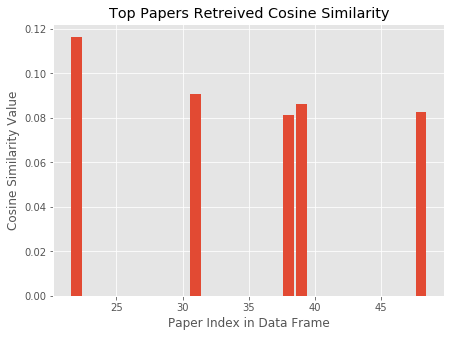

In [7]:
if (flag == False):
    values = [] # a list which will hold the cosine value of each paper outputted
    for i in answer_indicies:
        values.append(cosineSimilarities[i])
    print(values)
    print(answer_indicies)
    plt.figure(figsize=(7, 5))
    plt.bar(answer_indicies, values)
    plt.xlabel('Paper Index in Data Frame')
    plt.ylabel('Cosine Similarity Value')
    plt.title('Top Papers Retreived Cosine Similarity')
    plt.show()

<p>In the below cell, the code verifies whether or not the cosine similarity is >=0.05.  </p>

In [8]:
#loop on the top 5 indicies and display the title, abstract, and fulltext of the paper that was fetched from the search
if (flag == True):
    print("Sorry, no results")
else:
    counter =0
    for index in answer_indicies:
        if (cosineSimilarities[index]>=0.05):
            display(FullPaperDataframe.iloc[[index]]['title'])
        else:
            counter = counter+1
    if (counter == len(cosineSimilarities)):
        print("Sorry, no results")

38    Beyond R 0 : the importance of contact tracing when predicting epidemics
Name: title, dtype: object

48    Quantifying the success of measles vaccination campaigns in the Rohingya refugee camps
Name: title, dtype: object

39    COVID-19 coronavirus vaccine design using reverse vaccinology and machine 1 learning 2 3
Name: title, dtype: object

31    A spatial model of CoVID-19 transmission in England and Wales: early spread and peak timing
Name: title, dtype: object

22    On predicting the novel COVID-19 human infections by using Infectious Disease modelling method in the Indian State of Tamil Nadu during 2020
Name: title, dtype: object

<h4>STEP 4: LITERATURE CLUSTERING</h4>

<p>The second part of this notebook attempts to before K-Means clustering on the papers, such that each group of papers related together via certain keywords are grouped together.</p> 

<h5>Dimensionality Reduction</h5>
<p>At this stage, we have lots of features/words in the TIF-IDF matrix. However, to allow the K-means to perform better, dimensionality reduction is needed. Therefore, the PCA algorithm is chosen, as it is known that it performs well with K-Means </p>

In [9]:
from sklearn.decomposition import PCA #import PCA which will be used to reduce the dimensions of the dataset

pca = PCA(n_components=0.90,random_state=30)#keep 90% of the variance, and start random centroid @ 30
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

<h5>Elbow testing </h5>
<p>In order to determine how many clusters are needed for the K-means. A graph is plotted, the point at which the elbow forms is then searched. That value should be used as the number of clusters. </p>

100%|██████████| 8/8 [00:00<00:00, 13.02it/s]


<Figure size 1440x1440 with 0 Axes>

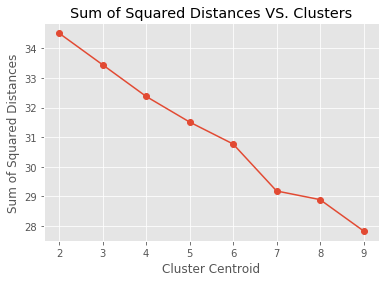

<Figure size 1440x1440 with 0 Axes>

In [10]:
from sklearn.cluster import KMeans #import kmeans which will be used to cluster the data


max_number_of_clusters = 9 #clusters can range from 2-max_number_of_clusters
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a 1 should be added.
Ks = range(2, max_number_of_clusters, 1) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k,random_state=30).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance for each k.
        
  #plot the elbow graph      
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

<h5>Elbow Graph Analysis </h5>
<p>As exhibited in the graph above the elbow forms at k = 7</p>
<h1 style ="color:red"> CHANGE K WHEN YOU RUN ALL THE DATASET. The above is for 50 papers</h1>

<h5> K-Means clustering</h5>
<p>Now that the number of clusters is known, k-means can be performed as shown in the cell below </p>

In [11]:
clusters = KMeans(n_clusters=7,random_state=30).fit_predict(tf_idf_norm_kmeans) #from the elbow graph we get the n_clusters
df =FullPaperDataframe.head(50).copy(deep=True)  #create a new df which will hold the papers attribute along with the cluster number

<p>In the below cell, the cluster to which the paper belongs is added to the dataframe</p>

In [12]:
df['clusters'] = clusters
df.head() #display the head

title  \
0  The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3   
1  Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                             
2  Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China                                                               
3  Relationship between Average Daily Temperature and Average Cumulative Daily Rate of Confirmed Cases of COVID-19                                        
4  CHEER: hierarCHical taxonomic classification for viral mEtagEnomic data via deep leaRning                                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      abstract  \
0  [{'text': 'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAPE and mutation experiments confirmed the importance of the previously predicted PK 37 structures for their function. Deletion experiments showed that although PKs are not essential 38', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'for replication, they provide genomes with a competitive advantage. However, although 39 replicons and full-length genomes lacking all PKs were replication competent, no

<h1 style="color:red">MISSING PLOTTING, TSNE, KEYWORD (THEME) CATEGORIZATION</h1> 

In [13]:
# taged_abs=[]
# nouns=[]
# # tagging the clean data
# for val in clean_abs:
#     taged_abs.append(pos_tag(val.split()))
# # extracting the nouns
# for i in range(len(taged_abs)):
#     doc=[]
#     for j in range(len(taged_abs[i])):
#         if(taged_abs[i][j][1]=='NN' or taged_abs[i][j][1]=='NNS'):
#             doc.append(taged_abs[i][j][0])
#     nouns.append(doc)
        
# print(nouns)



Above we dcided to calculate the tf-idf so that we can represent every word that is present in the abstract quatitavily. By doing so we can further use the results in order model the topic according to the abstract that we just quatified.Furthermore we will use (Non-negative Matrix Factorization) NMF in order to come up with topic's that carry most weight in the abstract. To accomplish this we are going to filter all the nouns that are avaliable in the abstract and use them to represent the different topis that are avaliable.